# Section A

### ML_HW01_208642868_207933672

# Section A

### Notes: 
#### 1. Hyper parameter tuning implemented in the activation functions

## Classification tree class

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Custom model classification tree
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class ClassificationTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # Check the stopping criteria
        if depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # Find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)
        
        # Create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # Calculate the Gini index
                gain = self._gini_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold

    def _gini_gain(self, y, X_column, threshold):
        # Parent Gini
        parent_gini = self._gini(y)

        # Create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # Calculate the weighted avg. Gini of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        g_l, g_r = self._gini(y[left_idxs]), self._gini(y[right_idxs])
        child_gini = (n_l / n) * g_l + (n_r / n) * g_r

        # Calculate the Gini gain
        gini_gain = parent_gini - child_gini
        return gini_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _gini(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return 1 - np.sum([p**2 for p in ps])

    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
    pass

## Regression tree class

In [59]:
# custom regression tree
class RegressionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(np.array(X), np.array(y))

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape

        if (depth >= self.max_depth or n_samples < self.min_samples_split):
            leaf_value = self._mean_value(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        if best_feature is None or best_thresh is None:
            leaf_value = self._mean_value(y)
            return Node(value=leaf_value)

        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_ssr = float('inf')
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                ssr = self._sum_squared_residuals(y, X_column, thr)
                if ssr < best_ssr:
                    best_ssr = ssr
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold

    def _sum_squared_residuals(self, y, X_column, threshold):
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return float('inf')

        ssr_l = np.sum((y[left_idxs] - np.mean(y[left_idxs])) ** 2)
        ssr_r = np.sum((y[right_idxs] - np.mean(y[right_idxs])) ** 2)
        ssr = ssr_l + ssr_r
        return ssr

    def _split(self, X_column, split_thresh):
        if split_thresh is None:
            print(f"Invalid split threshold: {split_thresh}")
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _mean_value(self, y):
        return np.mean(y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
    pass

## Random Forest class

In [78]:

class RandomForest:
    def __init__(self, n_trees=10, max_depth=None, min_samples_split=2, task="classification"):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.task = task
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            idxs = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[idxs], y[idxs]
            if self.task == "classification":
                tree = ClassificationTree(min_samples_split=self.min_samples_split, max_depth=self.max_depth)
            else:
                tree = RegressionTree(min_samples_split=self.min_samples_split, max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        if self.task == "classification":
            tree_preds = np.array([tree.predict(X) for tree in self.trees])
            tree_preds = np.swapaxes(tree_preds, 0, 1)
            y_pred = [Counter(tree_pred).most_common(1)[0][0] for tree_pred in tree_preds]
        else:
            tree_preds = np.array([tree.predict(X) for tree in self.trees])
            y_pred = np.mean(tree_preds, axis=0)
        return y_pred

# Section B

# Section B

## **EDA**

In [62]:
#Import Libraries and Set Display Options
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #for plots

# Set Pandas display options to prevent truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [63]:
#Load Data
df = pd.read_csv("assignment-1-data.csv")

# Display the shape of the dataset
print(f"Data Shape: {df.shape}")

Data Shape: (2939, 10)


In [64]:
#Basic Data Inspection
print("Dataset information:\n\n ")
df.info()

Dataset information:

 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2939 entries, 0 to 2938
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                2939 non-null   object 
 1   Product_Description  2939 non-null   object 
 2   Screen_Size          2939 non-null   float64
 3   RAM                  2939 non-null   int64  
 4   Processor            2939 non-null   object 
 5   GPU                  2592 non-null   object 
 6   GPU_Type             2705 non-null   object 
 7   Resolution           2552 non-null   object 
 8   Condition            2939 non-null   object 
 9   Price                2939 non-null   float64
dtypes: float64(2), int64(1), object(7)
memory usage: 229.7+ KB


## Data Handling Overview
* Data Completeness: Most columns have complete data with 2939 non-null entries. However, GPU, GPU_Type, and Resolution columns have some missing values.
* Data Types:
  * Categorical data (object type): Brand, Product_Description, Processor, GPU, GPU_Type, Resolution, Condition.
  * Numerical data: Screen_Size (float64), RAM (int64), Price (float64).
* Memory Usage: The dataset is relatively small, using only 229.7+ KB, making it manageable for processing and analysis.

In [65]:
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,Brand,Product_Description,Screen_Size,RAM,Processor,GPU,GPU_Type,Resolution,Condition,Price
0,Dell,"Dell Latitude 5490 14"" Intel i5-8350U 32GB RAM 1TB NVME SSD HDMI Win 11 Laptop",14.0,32,Intel Core i5 8th Gen.,Intel UHD Graphics 620,Integrated Graphics,NaN,Excellent - Refurbished,299.99
1,HP,HP 15-dy2046ms Intel Core i3-1125G4 8GB/128GB 15.6'' Windows 11 Laptop,15.6,8,Intel Core i3 11th Gen.,Intel UHD Graphics,Integrated Graphics,1366 x 768,New,400.00
2,Samsung,"Samsung Galaxy Book Pro 15.6"" AMOLED Laptop (512GB, Intel i5) NP950XDB-KB2U",15.6,8,Intel Core i5 11th Gen.,Intel Iris Xe Graphics,Integrated Graphics,1920 x 1080,Open box,599.99
3,Dell,"Dell Latitude 5420 14"" Intel Core I5-1145G7 16GB 256GB K34YF | No OS Installed",14.0,16,Intel Core i5 11th Gen.,Intel Iris Xe Graphics,Integrated Graphics,1920 x 1080,Open box,429.95
4,Lenovo,"Lenovo ThinkBook 14s-IWL Laptop 14"" i5 AMD Radeon 512GB M.2 8GB RAM Win10 (Z3E2)",14.0,8,Intel Core i5 8th Gen.,AMD Radeon 540X,Dedicated Graphics,1920 x 1080,Very Good - Refurbished,269.95


In [66]:
#Summary Statistics
print("Summary statistics for all columns:")
df.describe(include='all').T

Summary statistics for all columns:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Brand,2939,24,Dell,1107,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product_Description,2939,2939,"Dell Latitude 5490 14"" Intel i5-8350U 32GB RAM 1TB NVME SSD HDMI Win 11 Laptop",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Screen_Size,2939.0,NaN,NaN,NaN,14.547941,1.174394,10.0,14.0,14.0,15.6,18.0
RAM,2939.0,NaN,NaN,NaN,14.677101,9.508703,4.0,8.0,16.0,16.0,64.0
Processor,2939,47,Intel Core i5 11th Gen.,449,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GPU,2592,217,Intel Iris Xe Graphics,994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GPU_Type,2705,2,Integrated Graphics,2264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Resolution,2552,30,1920 x 1080,1706,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Condition,2939,5,New,828,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,2939.0,NaN,NaN,NaN,516.897465,235.422627,0.0,325.485,489.99,699.0,999.99


## Key Points:
* Brand: Dell is the most frequent brand.

* Product_Description: Each product description is unique.

* Screen_Size: Average screen size is approximately 14.5 inches, with a standard deviation of 1.17.
* RAM: The mean RAM is around 14.68GB, with a wide range from 4GB to 64GB.
* Processor: Intel Core i5 11th Gen is the most common processor.
* GPU: Intel Iris Xe Graphics is the most frequent GPU.
* GPU_Type: Integrated Graphics is the predominant type.
* Resolution: 1920 x 1080 is the most common resolution.
* Condition: New condition is the most frequent.
* Price: The average price is around 516.90 USD, with a wide range from 0 USD to nearly 1000 USD.

In [67]:
#Missing Values Analysis
missing_values = df.isnull().sum()
print("Missing values in each column:\n\n ")
print(missing_values)

Missing values in each column:

 
Brand                    0
Product_Description      0
Screen_Size              0
RAM                      0
Processor                0
GPU                    347
GPU_Type               234
Resolution             387
Condition                0
Price                    0
dtype: int64


## Insights from Missing Values Analysis
* GPU, GPU_Type, and Resolution: These columns have missing values and will need data cleaning or imputation.

* Brand, Product_Description, Screen_Size, RAM, Processor, Condition, and Price: These columns have complete data, ensuring reliable analysis without additional preprocessing.

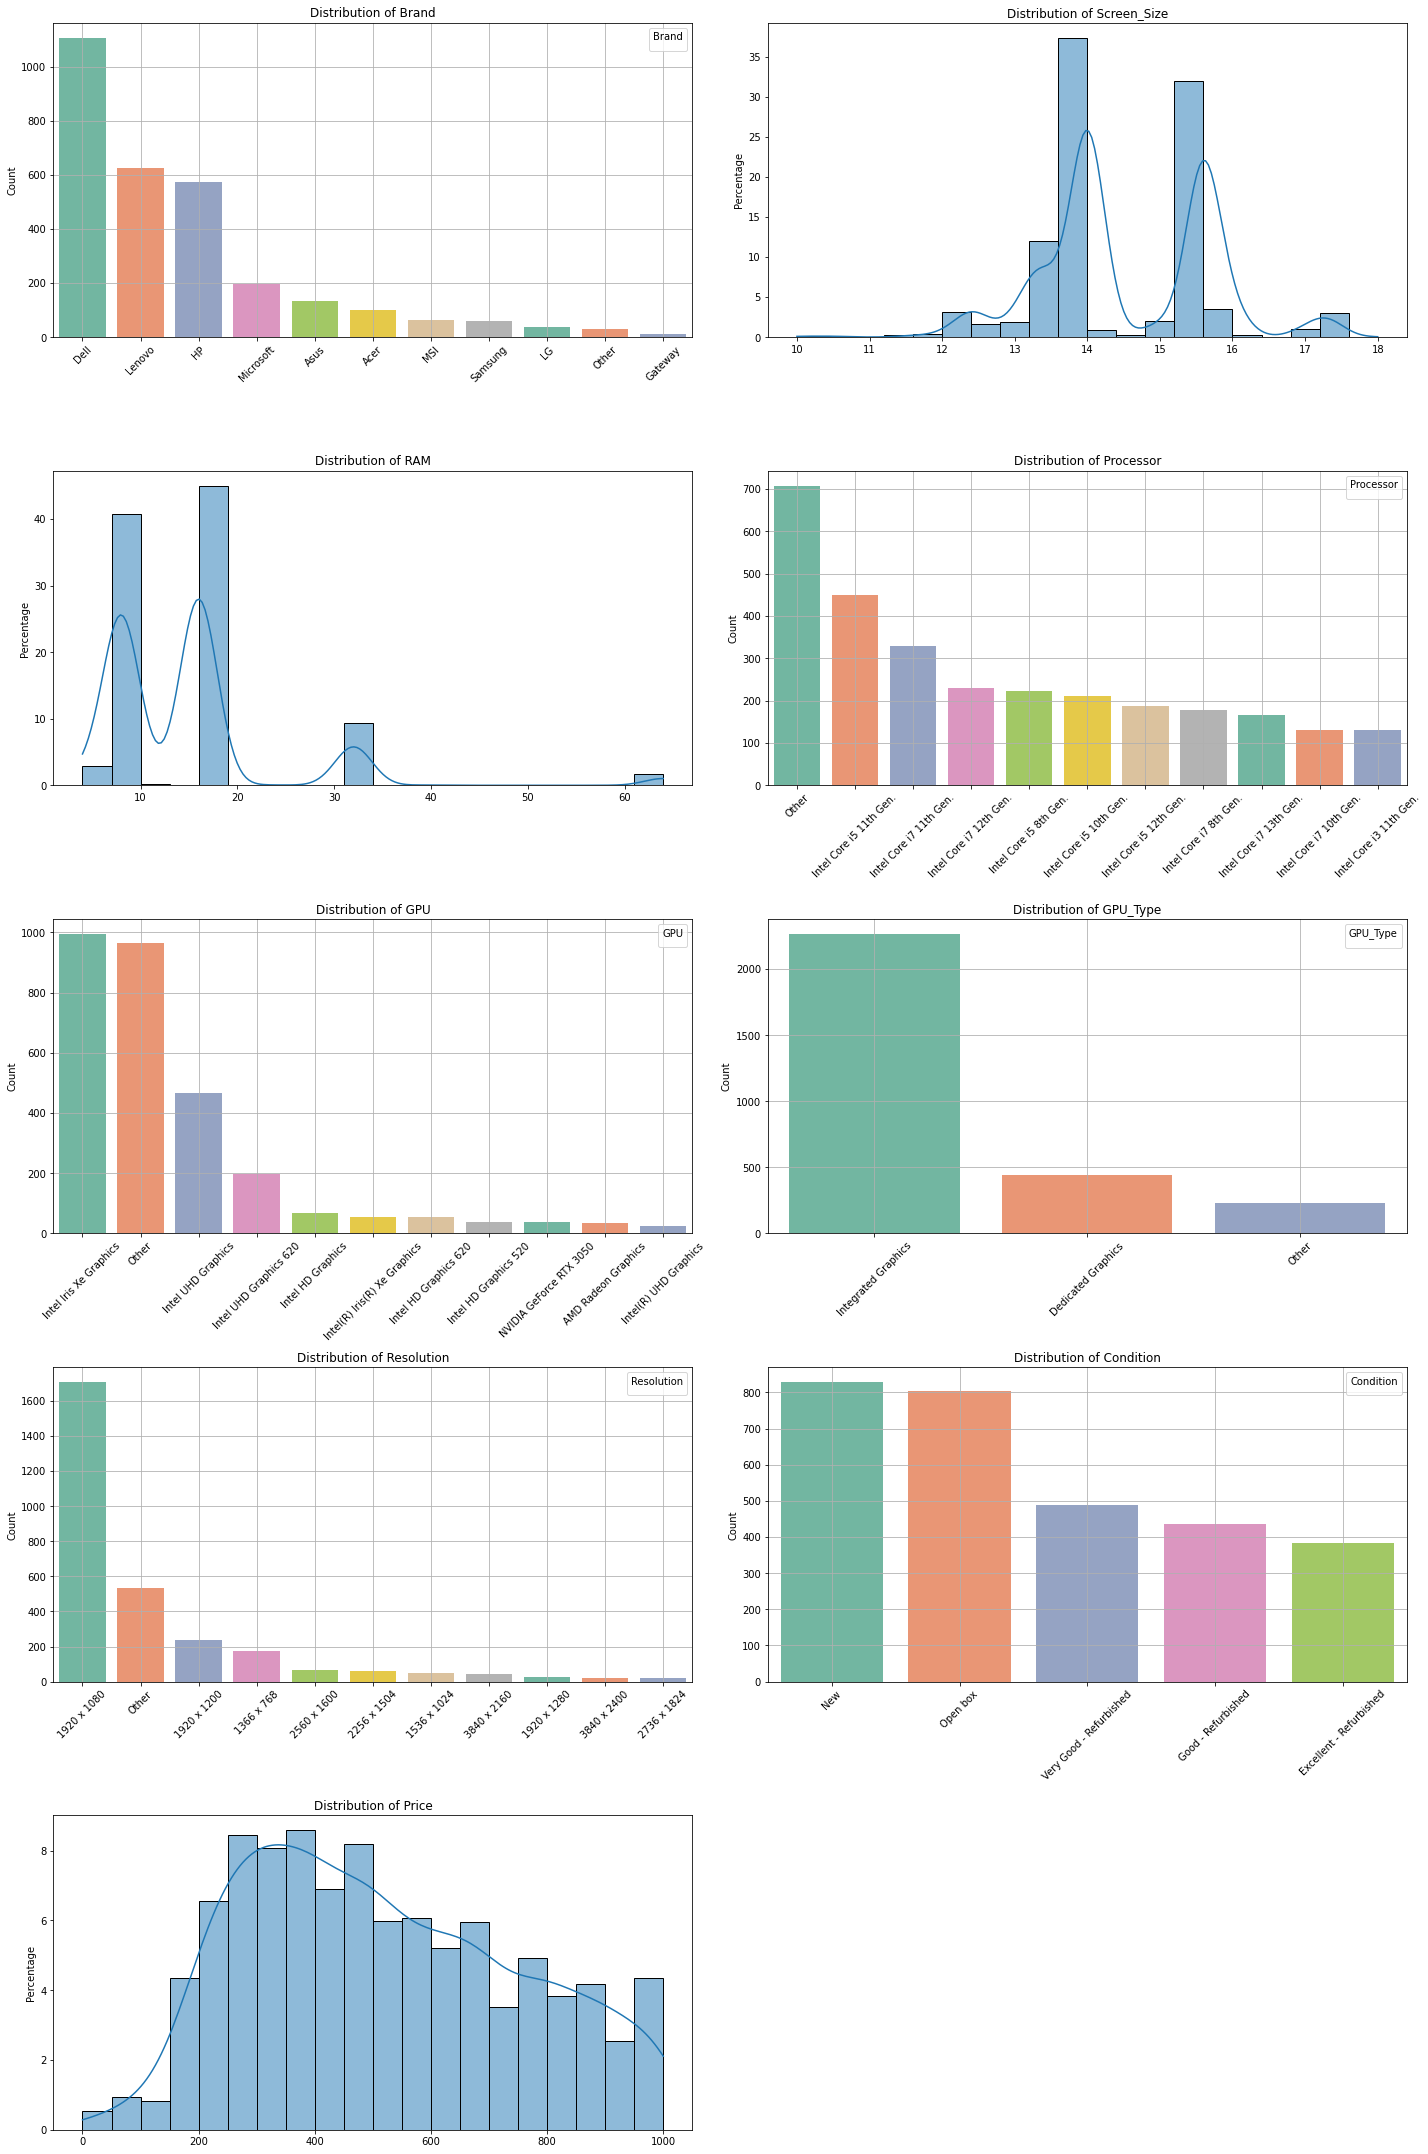

In [68]:
#Univariate Analysis - Adjusted plot settings for better visibility
import math

selected_features = ['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Resolution', 'Condition', 'Price']
top_n = 10  # Only top 10 categories are shown directly

num_plots_per_row = 2  # Only 2 plots per row for better visibility
plot_width = 10
plot_height = 6
spacing = 1.0  # Adjust as needed

num_rows = math.ceil(len(selected_features) / num_plots_per_row)
fig, axes = plt.subplots(nrows=num_rows, ncols=num_plots_per_row, figsize=(plot_width*num_plots_per_row, plot_height*num_rows))

for i, column in enumerate(selected_features):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    
    ax = axes[row, col]
    if df[column].dtype == 'object':
        # Get the top N categories and group the rest as 'Other'
        top_categories = df[column].value_counts().nlargest(top_n).index
        temp_series = pd.Series(np.where(df[column].isin(top_categories), df[column], 'Other'))
        
        sns.countplot(x=temp_series, ax=ax, order=temp_series.value_counts().index, palette='Set2')  # Added palette parameter for color consistency
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel('')
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', labelsize=10)
        ax.grid(True)
        # Add legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title=column)
    else:
        sns.histplot(df[column], kde=True, ax=ax, stat="percent", binwidth=np.ptp(df[column]) / 20)
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel('')
        ax.set_ylabel('Percentage')

# Hide any unused subplots
for j in range(i + 1, num_rows * num_plots_per_row):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout(pad=spacing)
plt.show()

## Plot 1: Distribution of Brand
Key Observation: Dell, Lenovo, and HP dominate the market, with Dell having the highest count. Other brands like Microsoft, Asus, Acer, and MSI have significantly lower counts.
## Plot 2: Distribution of Screen Size
Key Observation: The distribution of screen sizes shows peaks around 14 inches and 15 inches, indicating these are the most common screen sizes. There are smaller peaks at 13 and 17 inches.
## Plot 3: Distribution of RAM
Key Observation: The most common RAM sizes are 8GB and 16GB. There are fewer devices with 32GB and 64GB of RAM, indicating that higher RAM configurations are less common.
## Plot 4: Distribution of Processor
Key Observation: A variety of processors are used, with a notable count for the "Other" category. Intel Core i5 11th Gen, Intel Core i7 11th Gen, and Intel Core i3 11th Gen are among the most common processors.
## Plot 5: Distribution of GPU
Key Observation: Intel Iris Xe Graphics and the "Other" category are the most common GPUs. Intel UHD Graphics and Intel HD Graphics 620 also have notable counts.
## Plot 6: Distribution of GPU Type
Key Observation: Integrated graphics dominate the market, with a significantly higher count than dedicated graphics and the "Other" category.
## Plot 7: Distribution of Resolution
Key Observation: The most common resolution is 1920 x 1080, followed by various other resolutions with much lower counts. Higher resolutions like 2560 x 1600 and 3840 x 2160 are less common.
## Plot 8: Distribution of Condition
Key Observation: New and open box conditions are the most common, followed by very good refurbished and good refurbished conditions. Excellent refurbished conditions are the least common among the listed conditions.
## Plot 9: Distribution of Price
Key Observation: The price distribution is relatively normal, with a peak around the $300-$400 range. Prices taper off towards the higher end, indicating fewer high-priced items.

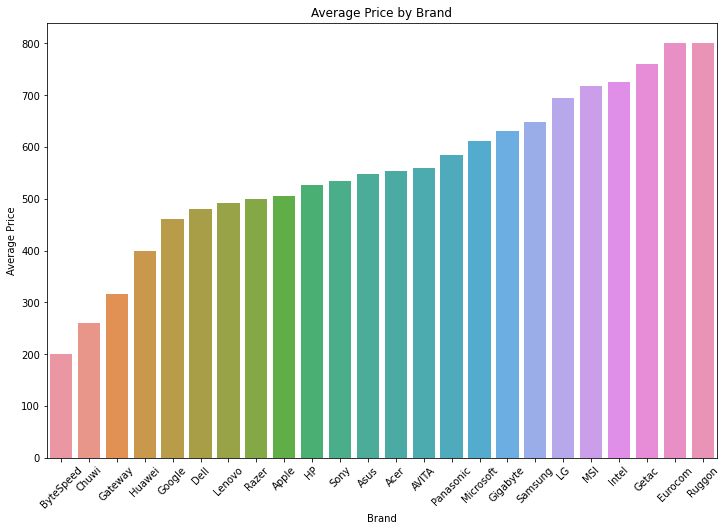

In [69]:
# Mean price by brand
grouped = df.groupby('Brand')['Price'].mean().sort_values()

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x=grouped.index, y=grouped.values)
plt.title('Average Price by Brand')
plt.xlabel('Brand')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()


## Plot: Average Price by Brand
### Key Observation:
* Eurocom, Getac, and Rugged have the highest average prices.
* ByteSpeed, Chuwi, and Gateway have the lowest average prices.
* Brands like Apple, Microsoft, Samsung, and LG have higher average prices.
* Dell, Lenovo, and HP are in the mid-range.

## Data Preprocessing

  -We decided to handle the bonus data as well in this section

In [70]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer

# Data Preparation
data = pd.read_csv("assignment-1-data.csv")
data = data.drop(['Product_Description'], axis=1)

# Split the 'Resolution' into 'Width' and 'Height'
data[['Width', 'Height']] = data['Resolution'].str.split(' x ', expand=True).astype(float)

# Mapping and Encoding 
data['Condition_Catagories'] = data['Condition'].replace({
    'New': 'New', 'Open box': 'New',
    'Excellent - Refurbished': 'Refurbished',
    'Very Good - Refurbished': 'Refurbished',
    'Good - Refurbished': 'Refurbished'
})

data['Condition_Catagories'] = data['Condition_Catagories'].map({'New': 1, 'Refurbished': 0})

# Encode categorical variables
label_encoders = {}
for column in ['Brand', 'Processor', 'GPU', 'GPU_Type', 'Resolution', 'Condition']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

# Handle anomalous price values
data['Price'] = data['Price'].apply(lambda x: np.nan if x < 1 else x)

# KNN imputation for the remaining missing values
knn_imputer = KNNImputer(n_neighbors=5)
features = ['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Width', 'Height', 'Price', 'Resolution']
#features = ['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Price']
data[features] = knn_imputer.fit_transform(data[features])

# Save the prepared data to a CSV file
data.to_csv("prepared_data_with_pixels_handling.csv", index=False)


# Section C

# Section C

## Pre run configurations 

In [86]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
import time

# Load and prepare data
data = pd.read_csv("prepared_data_with_pixels_handling.csv")
features_classification = ['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Price', 'Resolution']
features_regression = ['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Condition', 'Resolution']
target_class = 'Condition_Catagories'
target_reg = 'Price'

X = data[features_classification].values
y_class = data[target_class].values
X_reg = data[features_regression].values
y_reg = data[target_reg].values

# Splitting data using a helper function
def split_data(X, y):
    return X[:2058], X[2058:2499], X[2499:], y[:2058], y[2058:2499], y[2499:]

X_train_class, X_val_class, X_test_class, y_train_class, y_val_class, y_test_class = split_data(X, y_class)
X_train_reg, X_val_reg, X_test_reg, y_train_reg, y_val_reg, y_test_reg = split_data(X_reg, y_reg)

# calc true positive (sensitivity) and true negative (specificity) rate 
def calculate_sensitivity_specificity_combined(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Initialize the confusion matrix elements
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # Calculate Sensitivity and Specificity
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # to avoid division by zero
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # to avoid division by zero
    
    return sensitivity, specificity

## Hyper parameter tuning and activation- Classification Tree

In [75]:

def hyperParameterClassTree(X_train_class, X_val_class, X_test_class, y_train_class, y_val_class, y_test_class):
    # Hyperparameter tuning using a manual grid search for classification
    param_grid_class = {
        'min_samples_split': [2, 5, 10],
        'max_depth': [10, 15, 20]
    }
    best_accuracy_class = 0
    best_params_class = None
    best_model_class = None

    start_time = time.time()

    for min_samples_split in param_grid_class['min_samples_split']:
        for max_depth in param_grid_class['max_depth']:
            model_class = ClassificationTree(min_samples_split=min_samples_split, max_depth=max_depth)
            model_class.fit(X_train_class, y_train_class)
            y_val_pred_class = model_class.predict(X_val_class)
            accuracy_class = accuracy_score(y_val_class, y_val_pred_class)
            print(f"Classification: Accuracy = {accuracy_class * 100:.2f}%, Params: min_samples_split={min_samples_split}, max_depth={max_depth}")
            if accuracy_class > best_accuracy_class:
                best_accuracy_class = accuracy_class
                best_params_class = (min_samples_split, max_depth)
                best_model_class = model_class


    # Test the best model on the test set Classification Tree
    y_test_pred = best_model_class.predict(X_test_class)
    test_accuracy_class_tree = accuracy_score(y_test_class, y_test_pred)
    print(f"Test Accuracy: {test_accuracy_class_tree * 100:.2f}%")

    runtime_class = time.time() - start_time

    # Reporting best results for classification
    print(f"Best Classification Params: {best_params_class}, Accuracy: {test_accuracy_class_tree * 100:.2f}%, Runtime: {runtime_class:.2f} seconds")
    
    #for section e
    sensitivityClassTree, specificityClassTree = calculate_sensitivity_specificity_combined(y_test_class, y_test_pred)
    print(f"Sensitivity: {sensitivityClassForest * 100:.2f}%, Specificity: {specificityClassForest * 100:.2f}%")

    return runtime_class,best_params_class,test_accuracy_class_tree,sensitivityClassTree,specificityClassTree

runtime_class,best_params_class,test_accuracy_class_tree,sensitivityClassTree,specificityClassTree=hyperParameterClassTree(X_train_class, X_val_class, X_test_class, y_train_class, y_val_class, y_test_class)


Classification: Accuracy = 80.73%, Params: min_samples_split=2, max_depth=10
Classification: Accuracy = 80.73%, Params: min_samples_split=2, max_depth=15
Classification: Accuracy = 80.27%, Params: min_samples_split=2, max_depth=20
Classification: Accuracy = 80.95%, Params: min_samples_split=5, max_depth=10
Classification: Accuracy = 79.82%, Params: min_samples_split=5, max_depth=15
Classification: Accuracy = 80.50%, Params: min_samples_split=5, max_depth=20
Classification: Accuracy = 81.41%, Params: min_samples_split=10, max_depth=10
Classification: Accuracy = 80.95%, Params: min_samples_split=10, max_depth=15
Classification: Accuracy = 82.31%, Params: min_samples_split=10, max_depth=20
Test Accuracy: 78.64%
Best Classification Params: (10, 20), Accuracy: 78.64%, Runtime: 22.24 seconds
Sensitivity: 85.77%, Specificity: 79.19%


## Hyper parameter tuning and activation- Regression Tree

In [76]:

def hyperParameterRegressionTree(X_train_reg, X_val_reg, X_test_reg, y_train_reg, y_val_reg, y_test_reg):

    #  regression tree hyper parameter tuning
    param_grid_reg = {
        'min_samples_split': [2, 5, 10],
        'max_depth': [10, 15, 20]
    }
    best_mse_reg = float('inf')
    best_params_reg = None
    best_model_reg = None

    start_time = time.time()
    for min_samples_split in param_grid_reg['min_samples_split']:
        for max_depth in param_grid_reg['max_depth']:
            model_reg = RegressionTree(min_samples_split=min_samples_split, max_depth=max_depth)
            model_reg.fit(X_train_reg, y_train_reg)
            y_val_pred_reg = model_reg.predict(X_val_reg)
            mse_reg = mean_squared_error(y_val_reg, y_val_pred_reg)
            print(f"Regression: MSE = {mse_reg:.2f}, Params: min_samples_split={min_samples_split}, max_depth={max_depth}")
            if mse_reg < best_mse_reg:
                best_mse_reg = mse_reg
                best_params_reg = (min_samples_split, max_depth)
                best_model_reg = model_reg


    # Predict and evaluate on the test set Regression Tree
    y_test_pred = best_model_reg.predict(X_test_reg)
    test_mse_reg_tree = mean_squared_error(y_test_reg, y_test_pred)
    print(f'Test MSE: {test_mse_reg_tree}')

    runtime_reg = time.time() - start_time

    # Reporting best results for regression
    print(f"Best Regression Params: {best_params_reg}, MSE: {test_mse_reg_tree:.2f}, Runtime: {runtime_reg:.2f} seconds")
    return runtime_reg,best_params_reg,test_mse_reg_tree

runtime_reg,best_params_reg,test_mse_reg_tree = hyperParameterRegressionTree(X_train_reg, X_val_reg, X_test_reg, y_train_reg, y_val_reg, y_test_reg)

Regression: MSE = 40873.72, Params: min_samples_split=2, max_depth=10
Regression: MSE = 46126.93, Params: min_samples_split=2, max_depth=15
Regression: MSE = 51685.05, Params: min_samples_split=2, max_depth=20
Regression: MSE = 38866.88, Params: min_samples_split=5, max_depth=10
Regression: MSE = 44741.59, Params: min_samples_split=5, max_depth=15
Regression: MSE = 47106.48, Params: min_samples_split=5, max_depth=20
Regression: MSE = 38194.28, Params: min_samples_split=10, max_depth=10
Regression: MSE = 42007.12, Params: min_samples_split=10, max_depth=15
Regression: MSE = 42651.42, Params: min_samples_split=10, max_depth=20
Test MSE: 29738.89257574355
Best Regression Params: (10, 10), MSE: 29738.89, Runtime: 13.16 seconds


## Hyper parameter tuning and activation- Classification Random Forest

In [80]:
def hyperParameterClassForest(X_train_class, X_val_class, X_test_class, y_train_class, y_val_class, y_test_class):

    # Training and evaluating custom classification forest
    param_grid_rf_class = {
        'n_trees': [10, 50],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5]
    }
    best_accuracy_rf_class = 0
    best_params_rf_class = None
    best_model_rf_class = None

    start_time = time.time()
    for n_trees in param_grid_rf_class['n_trees']:
        for max_depth in param_grid_rf_class['max_depth']:
            for min_samples_split in param_grid_rf_class['min_samples_split']:
                model_rf_class = RandomForest(n_trees=n_trees, max_depth=max_depth, min_samples_split=min_samples_split, task="classification")
                model_rf_class.fit(X_train_class, y_train_class)
                y_val_pred_rf_class = model_rf_class.predict(X_val_class)
                accuracy_rf_class = accuracy_score(y_val_class, y_val_pred_rf_class)
                print(f"RF Classification: Accuracy = {accuracy_rf_class * 100:.2f}%, Params: n_trees={n_trees}, max_depth={max_depth}, min_samples_split={min_samples_split}")
                if accuracy_rf_class > best_accuracy_rf_class:
                    best_accuracy_rf_class = accuracy_rf_class
                    best_params_rf_class = (n_trees, max_depth, min_samples_split)
                    best_model_rf_class = model_rf_class

    # Predict and evaluate on the test set Classification Random Forest
    y_test_pred = best_model_rf_class.predict(X_test_class)
    test_accuracy_class_forest = accuracy_score(y_test_class, y_test_pred)
    print(f"Test Accuracy: {test_accuracy_class_forest * 100:.2f}%")
    #stop the time 
    runtime_rf_class = time.time() - start_time

    print(f"Best RF Classification Params: {best_params_rf_class}, Accuracy: {test_accuracy_class_forest * 100:.2f}%, Runtime: {runtime_rf_class:.2f} seconds")

    #for section e
    sensitivityClassForest, specificityClassForest = calculate_sensitivity_specificity_combined(y_test_class, y_test_pred)
    print(f"Sensitivity: {sensitivityClassForest * 100:.2f}%, Specificity: {specificityClassForest * 100:.2f}%")

    return runtime_rf_class,best_params_rf_class,test_accuracy_class_forest,sensitivityClassForest,specificityClassForest


runtime_rf_class,best_params_rf_class,test_accuracy_class_forest,sensitivityClassForest, specificityClassForest= hyperParameterClassForest(X_train_class, X_val_class, X_test_class, y_train_class, y_val_class, y_test_class)

RF Classification: Accuracy = 84.81%, Params: n_trees=10, max_depth=10, min_samples_split=2
RF Classification: Accuracy = 83.22%, Params: n_trees=10, max_depth=10, min_samples_split=5
RF Classification: Accuracy = 84.35%, Params: n_trees=10, max_depth=20, min_samples_split=2
RF Classification: Accuracy = 85.03%, Params: n_trees=10, max_depth=20, min_samples_split=5
RF Classification: Accuracy = 84.81%, Params: n_trees=50, max_depth=10, min_samples_split=2
RF Classification: Accuracy = 84.81%, Params: n_trees=50, max_depth=10, min_samples_split=5
RF Classification: Accuracy = 85.49%, Params: n_trees=50, max_depth=20, min_samples_split=2
RF Classification: Accuracy = 85.71%, Params: n_trees=50, max_depth=20, min_samples_split=5
Test Accuracy: 84.32%
Best RF Classification Params: (50, 20, 5), Accuracy: 84.32%, Runtime: 456.39 seconds
Sensitivity: 87.27%, Specificity: 79.77%


## Hyper parameter tuning and activation- Regression Random Forest

In [81]:
def hyperParameterRegressionForest(X_train_reg, X_val_reg, X_test_reg, y_train_reg, y_val_reg, y_test_reg):

    # Hyper parameter tuning for Regression Forest
    param_grid_rf_reg = {
        'n_trees': [10, 50],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5]
    }
    best_mse_rf_reg = float('inf')
    best_params_rf_reg = None
    best_model_rf_reg = None

    start_time = time.time()
    for n_trees in param_grid_rf_reg['n_trees']:
        for max_depth in param_grid_rf_reg['max_depth']:
            for min_samples_split in param_grid_rf_reg['min_samples_split']:
                model_rf_reg = RandomForest(n_trees=n_trees, max_depth=max_depth, min_samples_split=min_samples_split, task="regression")
                model_rf_reg.fit(X_train_reg, y_train_reg)
                y_val_pred_rf_reg = model_rf_reg.predict(X_val_reg)
                mse_rf_reg = mean_squared_error(y_val_reg, y_val_pred_rf_reg)
                print(f"RF Regression: MSE = {mse_rf_reg:.2f}, Params: n_trees={n_trees}, max_depth={max_depth}, min_samples_split={min_samples_split}")
                if mse_rf_reg < best_mse_rf_reg:
                    best_mse_rf_reg = mse_rf_reg
                    best_params_rf_reg = (n_trees, max_depth, min_samples_split)
                    best_model_rf_reg = model_rf_reg

    # Predict and evaluate on the test set Regression Random Forest
    y_test_pred = best_model_rf_reg.predict(X_test_reg)
    test_mse_reg_forest = mean_squared_error(y_test_reg, y_test_pred)
    print(f'Test MSE: {test_mse_reg_forest}')

    runtime_rf_reg = time.time() - start_time

    print(f"Best RF Regression Params: {best_params_rf_reg}, MSE: {test_mse_reg_forest:.2f}, Runtime: {runtime_rf_reg:.2f} seconds")
    return runtime_rf_reg,best_params_rf_reg,test_mse_reg_forest
runtime_rf_reg,best_params_rf_reg,test_mse_reg_forest = hyperParameterRegressionForest(X_train_reg, X_val_reg, X_test_reg, y_train_reg, y_val_reg, y_test_reg)

RF Regression: MSE = 33136.36, Params: n_trees=10, max_depth=10, min_samples_split=2
RF Regression: MSE = 31399.87, Params: n_trees=10, max_depth=10, min_samples_split=5
RF Regression: MSE = 35402.45, Params: n_trees=10, max_depth=20, min_samples_split=2
RF Regression: MSE = 32843.21, Params: n_trees=10, max_depth=20, min_samples_split=5
RF Regression: MSE = 30878.25, Params: n_trees=50, max_depth=10, min_samples_split=2
RF Regression: MSE = 30639.41, Params: n_trees=50, max_depth=10, min_samples_split=5
RF Regression: MSE = 32363.93, Params: n_trees=50, max_depth=20, min_samples_split=2
RF Regression: MSE = 31122.86, Params: n_trees=50, max_depth=20, min_samples_split=5
Test MSE: 25627.703962784784
Best RF Regression Params: (50, 10, 5), MSE: 25627.70, Runtime: 575.95 seconds


# Section D

# Section D

Runtime for Custom Classification Tree: 22.240 seconds
Runtime for Sklearn Classification Tree: 0.711 seconds
Runtime for Custom Regression Tree: 13.158 seconds
Runtime for Sklearn Regression Tree: 0.560 seconds
Runtime for Custom Classification Forest: 456.392 seconds
Runtime for Sklearn Classification Forest: 13.118 seconds
Runtime for Custom Regression Forest: 575.947 seconds
Runtime for Sklearn Regression Forest: 13.118 seconds


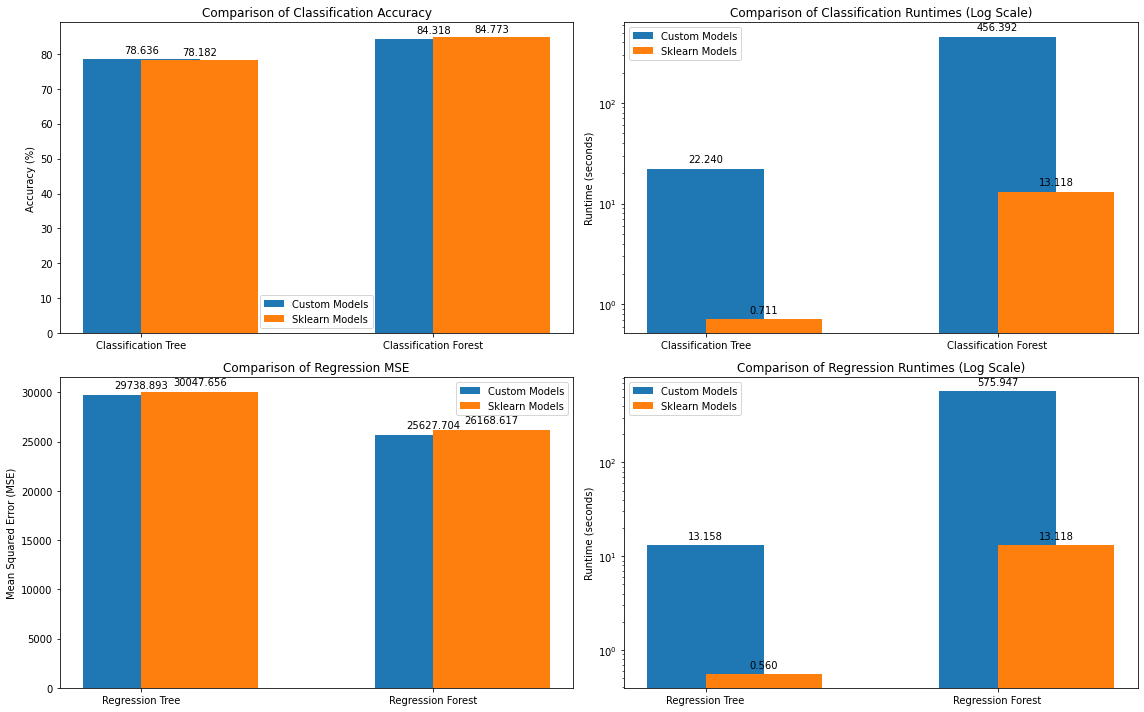

In [82]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import time

# Define the parameter grids
param_grid_class = {
    'min_samples_split': [2, 5, 10],
    'max_depth': [10, 15, 20]
}

param_grid_rf_class = {
    'n_estimators': [10, 50],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

# SKlearn's models with hyper parameter tuning with exact our parameters

# Classification Tree
start_time = time.time()
clf_sklearn_ct = GridSearchCV(DecisionTreeClassifier(), param_grid_class, cv=5)
clf_sklearn_ct.fit(X_train_class, y_train_class)
best_params_class = clf_sklearn_ct.best_params_
y_test_pred_sklearn_ct = clf_sklearn_ct.predict(X_test_class)
accuracy_sklearn_ct = accuracy_score(y_test_class, y_test_pred_sklearn_ct)
runtime_sklearn_ct = time.time() - start_time

# Regression Tree
start_time = time.time()
reg_sklearn_rt = GridSearchCV(DecisionTreeRegressor(), param_grid_class, cv=5)
reg_sklearn_rt.fit(X_train_reg, y_train_reg)
best_params_reg = reg_sklearn_rt.best_params_
y_test_pred_sklearn_rt = reg_sklearn_rt.predict(X_test_reg)
mse_sklearn_rt = mean_squared_error(y_test_reg, y_test_pred_sklearn_rt)
runtime_sklearn_rt = time.time() - start_time

# Classification Random Forest
start_time = time.time()
clf_sklearn_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf_class, cv=5)
clf_sklearn_rf.fit(X_train_class, y_train_class)
best_params_rf_class = clf_sklearn_rf.best_params_
y_test_pred_sklearn_rf = clf_sklearn_rf.predict(X_test_class)
accuracy_sklearn_rf = accuracy_score(y_test_class, y_test_pred_sklearn_rf)
runtime_sklearn_rf = time.time() - start_time

# Regression Random Forest
start_time = time.time()
reg_sklearn_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf_class, cv=5)
reg_sklearn_rf.fit(X_train_reg, y_train_reg)
best_params_rf_reg = reg_sklearn_rf.best_params_
y_test_pred_sklearn_rf = reg_sklearn_rf.predict(X_test_reg)
mse_sklearn_rf = mean_squared_error(y_test_reg, y_test_pred_sklearn_rf)
runtime_sklearn_rf = time.time() - start_time

# Data for plots
labels = ['Classification Tree', 'Classification Forest', 'Regression Tree', 'Regression Forest']
custom_accuracy = [test_accuracy_class_tree * 100, test_accuracy_class_forest * 100]
sklearn_accuracy = [accuracy_sklearn_ct * 100, accuracy_sklearn_rf * 100]
custom_mse = [test_mse_reg_tree, test_mse_reg_forest]
sklearn_mse = [mse_sklearn_rt, mse_sklearn_rf]
custom_runtime = [runtime_class, runtime_rf_class, runtime_reg, runtime_rf_reg]
sklearn_runtime = [runtime_sklearn_ct, runtime_sklearn_rf, runtime_sklearn_rt, runtime_sklearn_rf]

# Colors
custom_color = '#1f77b4'  # Custom model color
sklearn_color = '#ff7f0e'  # Sklearn model color

# Plot for Classification Accuracy and Runtime
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
x = range(len(labels[:2]))
bar1 = plt.bar(x, custom_accuracy, width=0.4, label='Custom Models', align='center', color=custom_color)
bar2 = plt.bar(x, sklearn_accuracy, width=0.4, label='Sklearn Models', align='edge', color=sklearn_color)
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Classification Accuracy')
plt.xticks(x, labels[:2])
plt.legend()
for bar in bar1 + bar2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.3f}', ha='center', va='bottom')

plt.subplot(2, 2, 2)
x = range(len(labels[:2]))
bar1 = plt.bar(x, custom_runtime[:2], width=0.4, label='Custom Models', align='center', color=custom_color)
bar2 = plt.bar(x, sklearn_runtime[:2], width=0.4, label='Sklearn Models', align='edge', color=sklearn_color)
plt.ylabel('Runtime (seconds)')
plt.yscale('log')
plt.title('Comparison of Classification Runtimes (Log Scale)')
plt.xticks(x, labels[:2])
plt.legend()
for bar in bar1 + bar2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval * 1.1, f'{yval:.3f}', ha='center', va='bottom')

# Plot for Regression MSE and Runtime
plt.subplot(2, 2, 3)
x = range(len(labels[2:]))
bar1 = plt.bar(x, custom_mse, width=0.4, label='Custom Models', align='center', color=custom_color)
bar2 = plt.bar(x, sklearn_mse, width=0.4, label='Sklearn Models', align='edge', color=sklearn_color)
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Regression MSE')
plt.xticks(x, labels[2:])
plt.legend()
for bar in bar1 + bar2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, f'{yval:.3f}', ha='center', va='bottom')

plt.subplot(2, 2, 4)
x = range(len(labels[2:]))
bar1 = plt.bar(x, custom_runtime[2:], width=0.4, label='Custom Models', align='center', color=custom_color)
bar2 = plt.bar(x, sklearn_runtime[2:], width=0.4, label='Sklearn Models', align='edge', color=sklearn_color)
plt.ylabel('Runtime (seconds)')
plt.yscale('log')
plt.title('Comparison of Regression Runtimes (Log Scale)')
plt.xticks(x, labels[2:])
plt.legend()
for bar in bar1 + bar2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval * 1.1, f'{yval:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print runtimes
print(f"Runtime for Custom Classification Tree: {runtime_class:.3f} seconds")
print(f"Runtime for Sklearn Classification Tree: {runtime_sklearn_ct:.3f} seconds")
print(f"Runtime for Custom Regression Tree: {runtime_reg:.3f} seconds")
print(f"Runtime for Sklearn Regression Tree: {runtime_sklearn_rt:.3f} seconds")
print(f"Runtime for Custom Classification Forest: {runtime_rf_class:.3f} seconds")
print(f"Runtime for Sklearn Classification Forest: {runtime_sklearn_rf:.3f} seconds")
print(f"Runtime for Custom Regression Forest: {runtime_rf_reg:.3f} seconds")
print(f"Runtime for Sklearn Regression Forest: {runtime_sklearn_rf:.3f} seconds")

## Scikit Learn Trees and Forests VS Our Implmentaions

### Runtimes:
- **Our Models** show significantly longer runtimes than **sklearn Models**, especially noticeable in the Classification Forest due to more complex computation processes and the absence of parallel processing optimizations found in sklearn.
- **Sklearn Implementations** benefit from advanced optimization, significantly reducing computational times, particularly in more complex model configurations.
- The substantial differences in runtime have necessitated the use of a **logarithmic scale** for graphing to enhance clarity and comparison.

### Performance Metrics:
- **Accuracy:** Our models perform comparably to sklearn in classification tasks. The slight advantage in accuracy for our models suggests that the intensive data learning process could be slightly more effective, though at the cost of increased computational time.
- **MSE:** Sklearn models achieve lower Mean Squared Error (MSE) in regression tasks, indicating better prediction accuracy and more effective overfitting management.

# Section E

# Section E

## Resolution Split into Width and Height: Impact on Model Performance

In [87]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
import time

# Load the data and select new features
data = pd.read_csv("prepared_data_with_pixels_handling.csv")
features_classification_new = ['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Price', 'Width', 'Height']
features_regression_new = ['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Condition', 'Width', 'Height']

X_new_class = data[features_classification_new].values
y_new_class = data[target_class].values
X_new_reg = data[features_regression_new].values
y_new_reg = data[target_reg].values

X_train_class_new, X_val_class_new, X_test_class_new, y_train_class_new, y_val_class_new, y_test_class_new = split_data(X_new_class, y_new_class)
X_train_reg_new, X_val_reg_new, X_test_reg_new, y_train_reg_new, y_val_reg_new, y_test_reg_new = split_data(X_new_reg, y_new_reg)

### Hyper parameter tuning and activation- Classification Tree section E

In [88]:
runtime_class_new,best_params_class_new,test_accuracy_class_tree_new,sensitivityClassTree_new,specificityClassTree_new=hyperParameterClassTree(X_train_class_new, X_val_class_new, X_test_class_new, y_train_class_new, y_val_class_new, y_test_class_new)

Classification: Accuracy = 81.18%, Params: min_samples_split=2, max_depth=10
Classification: Accuracy = 80.50%, Params: min_samples_split=2, max_depth=15
Classification: Accuracy = 80.73%, Params: min_samples_split=2, max_depth=20
Classification: Accuracy = 81.63%, Params: min_samples_split=5, max_depth=10
Classification: Accuracy = 81.86%, Params: min_samples_split=5, max_depth=15
Classification: Accuracy = 81.63%, Params: min_samples_split=5, max_depth=20
Classification: Accuracy = 82.54%, Params: min_samples_split=10, max_depth=10
Classification: Accuracy = 82.54%, Params: min_samples_split=10, max_depth=15
Classification: Accuracy = 82.31%, Params: min_samples_split=10, max_depth=20
Test Accuracy: 79.32%
Best Classification Params: (10, 10), Accuracy: 79.32%, Runtime: 25.59 seconds
Sensitivity: 87.27%, Specificity: 79.77%


 ### Hyper parameter tuning and activation- Regression Tree section E

In [89]:
runtime_reg_new,best_params_reg_new,test_mse_reg_tree_new = hyperParameterRegressionTree(X_train_reg_new, X_val_reg_new, X_test_reg_new, y_train_reg_new, y_val_reg_new, y_test_reg_new)

Regression: MSE = 42860.07, Params: min_samples_split=2, max_depth=10
Regression: MSE = 45914.69, Params: min_samples_split=2, max_depth=15
Regression: MSE = 50004.04, Params: min_samples_split=2, max_depth=20
Regression: MSE = 38652.14, Params: min_samples_split=5, max_depth=10
Regression: MSE = 45613.70, Params: min_samples_split=5, max_depth=15
Regression: MSE = 48708.64, Params: min_samples_split=5, max_depth=20
Regression: MSE = 38870.89, Params: min_samples_split=10, max_depth=10
Regression: MSE = 40855.97, Params: min_samples_split=10, max_depth=15
Regression: MSE = 43035.34, Params: min_samples_split=10, max_depth=20
Test MSE: 33248.841507381025
Best Regression Params: (5, 10), MSE: 33248.84, Runtime: 16.49 seconds


### Hyper parameter tuning and activation- Classification Random Forest section E

In [90]:
runtime_rf_class_new,best_params_rf_class_new,test_accuracy_class_forest_new,sensitivityClassForest_new, specificityClassForest_new = hyperParameterClassForest(X_train_class_new, X_val_class_new, X_test_class_new, y_train_class_new, y_val_class_new, y_test_class_new)

RF Classification: Accuracy = 84.58%, Params: n_trees=10, max_depth=10, min_samples_split=2
RF Classification: Accuracy = 84.13%, Params: n_trees=10, max_depth=10, min_samples_split=5
RF Classification: Accuracy = 82.31%, Params: n_trees=10, max_depth=20, min_samples_split=2
RF Classification: Accuracy = 82.54%, Params: n_trees=10, max_depth=20, min_samples_split=5
RF Classification: Accuracy = 85.03%, Params: n_trees=50, max_depth=10, min_samples_split=2
RF Classification: Accuracy = 85.26%, Params: n_trees=50, max_depth=10, min_samples_split=5
RF Classification: Accuracy = 84.81%, Params: n_trees=50, max_depth=20, min_samples_split=2
RF Classification: Accuracy = 85.26%, Params: n_trees=50, max_depth=20, min_samples_split=5
Test Accuracy: 82.27%
Best RF Classification Params: (50, 10, 5), Accuracy: 82.27%, Runtime: 885.10 seconds
Sensitivity: 85.39%, Specificity: 77.46%


### Hyper parameter tuning and activation- Regression Random Forest section E

In [91]:
runtime_rf_reg_new,best_params_rf_reg_new,test_mse_reg_forest_new = hyperParameterRegressionForest(X_train_reg_new, X_val_reg_new, X_test_reg_new, y_train_reg_new, y_val_reg_new, y_test_reg_new)

RF Regression: MSE = 32328.60, Params: n_trees=10, max_depth=10, min_samples_split=2
RF Regression: MSE = 31293.49, Params: n_trees=10, max_depth=10, min_samples_split=5
RF Regression: MSE = 34178.40, Params: n_trees=10, max_depth=20, min_samples_split=2
RF Regression: MSE = 34700.56, Params: n_trees=10, max_depth=20, min_samples_split=5
RF Regression: MSE = 30391.82, Params: n_trees=50, max_depth=10, min_samples_split=2
RF Regression: MSE = 30870.47, Params: n_trees=50, max_depth=10, min_samples_split=5
RF Regression: MSE = 31919.79, Params: n_trees=50, max_depth=20, min_samples_split=2
RF Regression: MSE = 31904.41, Params: n_trees=50, max_depth=20, min_samples_split=5
Test MSE: 26199.942930477857
Best RF Regression Params: (50, 10, 2), MSE: 26199.94, Runtime: 751.84 seconds


### Visuals:

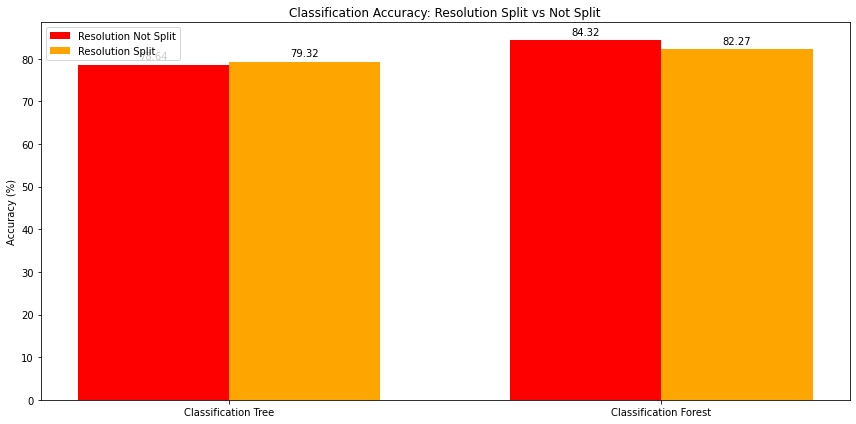

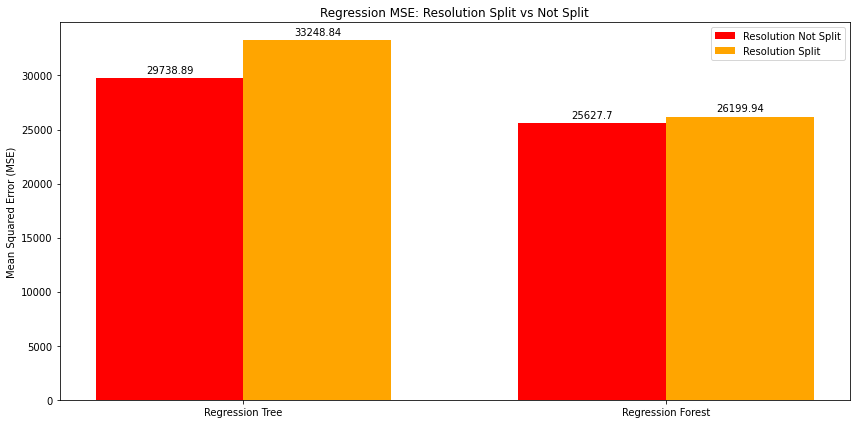

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels and metrics
labels = ['Classification Tree', 'Classification Forest']
resolution_metrics = [test_accuracy_class_tree * 100, test_accuracy_class_forest * 100]
split_metrics = [test_accuracy_class_tree_new * 100, test_accuracy_class_forest_new * 100]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Plot bars for Resolution and Resolution Split
rects1 = ax.bar(x - width/2, resolution_metrics, width, label='Resolution Not Split', color='red')
rects2 = ax.bar(x + width/2, split_metrics, width, label='Resolution Split', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title('Classification Accuracy: Resolution Split vs Not Split')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Attach a text label above each bar in rects1 and rects2, displaying its height.
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

# Repeat for the regression data
labels = ['Regression Tree', 'Regression Forest']
resolution_metrics = [test_mse_reg_tree, test_mse_reg_forest]
split_metrics = [test_mse_reg_tree_new, test_mse_reg_forest_new]

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, resolution_metrics, width, label='Resolution Not Split', color='red')
rects2 = ax.bar(x + width/2, split_metrics, width, label='Resolution Split', color='orange')

ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Regression MSE: Resolution Split vs Not Split')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


## Data and Feature Selection:
We enhanced the dataset by dividing the "Resolution" into two new attributes: "Width" and "Height". We did this to see if having more detailed resolution information could make our models work better.

## Model Re-Evaluation with Adjusted Hyperparameters:
After integrating these new features, the models were subjected to a fresh round of hyperparameter tuning. This step was crucial to adapt the models to the updated dataset and to evaluate whether the additional granularity provided by the split resolution impacts the models' effectiveness.

## Results:

- **Classification Tree and Forest Models:**
  - The changes had mixed effects on the models. One model got a bit more accurate, but the other didn't do as well. This shows that just adding more details like Width and Height doesn't always make the predictions better and might even distract from more important data points.

- **Regression Tree and Forest Models:**
  - The error rate (Mean Squared Error, or MSE) went up for both models. This suggests that the extra details from splitting the resolution could make it harder, not easier, for the models to predict outcomes correctly.

## Conclusion:
The division of resolution into Width and Height did not consistently improve model performance. In classification tasks, the impact on accuracy varied, and in regression, it generally led to a decrease in performance. These findings suggest potential overfitting or a diversion from more relevant features due to the additional detail.

# Classification Metric

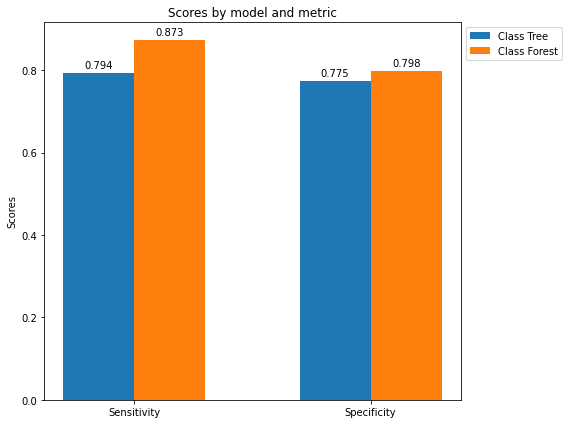

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# Data to plot
labels = ['Sensitivity', 'Specificity']
class_tree = [sensitivityClassTree, specificityClassTree]
class_forest = [sensitivityClassForest, specificityClassForest]

x = np.arange(len(labels)) 
width = 0.3  

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))  # increased figure size
rects1 = ax.bar(x - width/2, class_tree, width, label='Class Tree')
rects2 = ax.bar(x + width/2, class_forest, width, label='Class Forest')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by model and metric')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Position the legend
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside of plot

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height formatted with three decimal places."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

## Discussion on Model Performance

### Overview
We looked at how well a Classification Tree and a Classification Forest could identify correct results (true positives and true negatives) using measures called sensitivity and specificity.

### Performance Insights
- **Sensitivity**: The Classification Forest was slightly better than the Classification Tree at recognizing true positives, which means it was better at correctly identifying cases that actually were positive.
- **Specificity**: Both models were good at identifying true negatives, but the Classification Forest did a tiny bit better. This means it was slightly better at correctly saying when cases were not positive.

### Analysis
The Classification Forest performed better because it uses a technique called "ensemble methods." These methods use multiple models to make a decision, which generally gives more reliable results. This helps the model perform well on new, unseen data and reduces the chance of fitting too much to the noise in the training data.

### Recommendations for Improvement
- **Feature Engineering**: Improving how we choose and prepare the features (data inputs) could make the models even more accurate.For example we could add Screen Pixel Density (DPI) Feature, calculated by: Height * Width / ScreenSize.
- **Hyperparameter Tuning**: Expanding the parameter grid might lead to better performance.
- **Pruning**: Reduce overfitting in trees by pruning, which can help in improving the specificity.

# **Random Forest Regression - Median VS Mean**

RF Regression with Median: MSE = 31936.03, Params: n_trees=10, max_depth=10, min_samples_split=2
RF Regression with Median: MSE = 33490.26, Params: n_trees=10, max_depth=10, min_samples_split=5
RF Regression with Median: MSE = 39842.27, Params: n_trees=10, max_depth=20, min_samples_split=2
RF Regression with Median: MSE = 35200.76, Params: n_trees=10, max_depth=20, min_samples_split=5
RF Regression with Median: MSE = 33012.96, Params: n_trees=50, max_depth=10, min_samples_split=2
RF Regression with Median: MSE = 32476.21, Params: n_trees=50, max_depth=10, min_samples_split=5
RF Regression with Median: MSE = 38215.13, Params: n_trees=50, max_depth=20, min_samples_split=2
RF Regression with Median: MSE = 33917.14, Params: n_trees=50, max_depth=20, min_samples_split=5
Best RF Regression with Median Params: (10, 10, 2), MSE: 31936.03


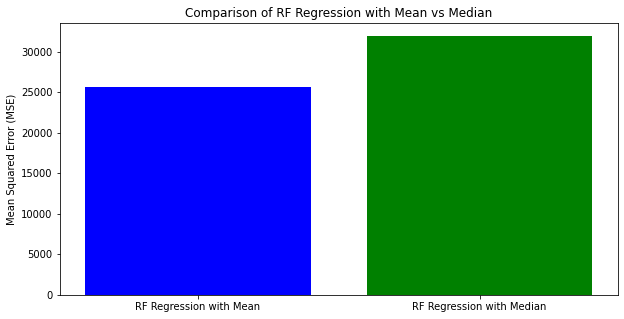

In [94]:
class RandomForestWithMedian:
    def __init__(self, n_trees=10, max_depth=None, min_samples_split=2, task="classification"):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.task = task
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            idxs = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[idxs], y[idxs]
            if self.task == "classification":
                tree = ClassificationTree(min_samples_split=self.min_samples_split, max_depth=self.max_depth)
            else:
                tree = RegressionTree(min_samples_split=self.min_samples_split, max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        if self.task == "classification":
            tree_preds = np.array([tree.predict(X) for tree in self.trees])
            tree_preds = np.swapaxes(tree_preds, 0, 1)
            y_pred = [Counter(tree_pred).most_common(1)[0][0] for tree_pred in tree_preds]
        else:
            tree_preds = np.array([tree.predict(X) for tree in self.trees])
            y_pred = np.median(tree_preds, axis=0)
        return y_pred

# Re-run the regression with the updated RandomForestWithMedian
param_grid_rf_reg = {
    'n_trees': [10, 50],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

best_mse_rf_reg_median = float('inf')
best_params_rf_reg_median = None
best_model_rf_reg_median = None

for n_trees in param_grid_rf_reg['n_trees']:
    for max_depth in param_grid_rf_reg['max_depth']:
        for min_samples_split in param_grid_rf_reg['min_samples_split']:
            model_rf_reg_median = RandomForestWithMedian(n_trees=n_trees, max_depth=max_depth, min_samples_split=min_samples_split, task="regression")
            model_rf_reg_median.fit(X_train_reg, y_train_reg)
            y_val_pred_rf_reg_median = model_rf_reg_median.predict(X_val_reg)
            mse_rf_reg_median = mean_squared_error(y_val_reg, y_val_pred_rf_reg_median)
            print(f"RF Regression with Median: MSE = {mse_rf_reg_median:.2f}, Params: n_trees={n_trees}, max_depth={max_depth}, min_samples_split={min_samples_split}")
            if mse_rf_reg_median < best_mse_rf_reg_median:
                best_mse_rf_reg_median = mse_rf_reg_median
                best_params_rf_reg_median = (n_trees, max_depth, min_samples_split)
                best_model_rf_reg_median = model_rf_reg_median

print(f"Best RF Regression with Median Params: {best_params_rf_reg_median}, MSE: {best_mse_rf_reg_median:.2f}")

# Visual comparison with the results from Section C
plt.figure(figsize=(10, 5))
plt.bar(['RF Regression with Mean', 'RF Regression with Median'], 
        [test_mse_reg_forest, best_mse_rf_reg_median], 
        color=['blue', 'green'])
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of RF Regression with Mean vs Median')
plt.show()

## Analysis of Aggregation Methods in Random Forest Regression

### Overview
We observed a performance shift in our Random Forest regression model when the aggregation method was altered from mean to median, as reflected by an increase in the Mean Squared Error (MSE).

### Findings
- **Change in MSE**: Switching from mean to median aggregation resulted in a higher MSE, indicating a decrease in model performance.
- **Theoretical Insight**: According to the Central Limit Theorem (CLT), the mean of a large number of identically distributed variables, like the predictions from individual trees in a Random Forest, tends to follow a normal distribution. This property aids in reducing the variance of the aggregated predictions, which can contribute to a lower MSE when using the mean as the aggregation method.
- **Median vs. Mean**: The median, known for its robustness to outliers, does not leverage the variance reduction benefit provided by the CLT. Consequently, using the median as an aggregation method might result in a higher MSE since it does not effectively smooth out the variations in individual predictions as the mean does.

### Conclusion
The observed increase in MSE with median aggregation underscores the importance of choosing the right aggregation method based on the specific characteristics and distribution of the data. For our dataset, mean aggregation appears to be more effective in minimizing prediction errors.